In [10]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from contextily import Place
import folium
from shapely.geometry import Polygon
import ast
import pandas as pd
from shapely.geometry import Point, LineString
from networkx.readwrite import json_graph
import numpy as np
import random
from numpy.random import choice
import seaborn as sns
from branca.colormap import LinearColormap,StepColormap
import plotly.express as px
from branca.colormap import linear
from pyproj import Transformer, transform
import pyproj
from GAclass import GeneticAlgorithm
from GAMOclass import GAMO
import pickle
import os
from GenerateSubgraphClass import get_subgraph,cartesian_to_geographical,geographical_to_cartesian,get_points_inside_circle2

ox.settings.log_console=True
ox.settings.use_cache=True
plt.rcParams["figure.dpi"] = 100
city_name = "Brasov, Romania"
# Define the projection systems
source_crs = 'epsg:32635' # Coordinate system of the file
#print(G.graph["crs"])
target_crs = 'epsg:4326' # Global lat-lon coordinate system


UsageError: Line magic function `%%time` not found.


In [2]:
# Check if the graph has already been saved
graph_file_geographical = "graph_geographical_coords.pkl"

if os.path.exists(graph_file_geographical):
    with open(graph_file_geographical, "rb") as f:
        # Load the graph from file
        G = pickle.load(f)
else:
    # Create the graph and save it
    G = ox.graph_from_place(city_name, network_type="drive", simplify=True)

# Load the coordinates DataFrame
df_coordinates = pd.read_csv('AugmentedPoints.csv')

# Add custom node weights based on page rank
node_weights_dict = dict(zip(df_coordinates['Node_ID'], df_coordinates['influence_factor_page_rank_minMax']))
nx.set_node_attributes(G, node_weights_dict, 'weight')

# Check if the projected graph has already been saved
projected_graph_file = "graph_cartesian_coords.pkl"
if os.path.exists(projected_graph_file):
    with open(projected_graph_file, "rb") as f:
        # Load the projected graph from file
        G_projected = pickle.load(f)
else:
    # Project the graph and save it
    G_projected = ox.project_graph(G)

# Convert graphs to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)
nodes_cartesian, edge_cartesian = ox.graph_to_gdfs(G_projected)

In [7]:
data = get_subgraph()
origin = data['origin']
destination = data['destination']
radius = data['radius']
center_point= data['center_point']
route_gdf = data['route_gdf']
route = data['route']
successors_dict = data['successors_dict']
subset_of_nodes = data['subset_of_nodes']
nodes_geographical = data['nodes_geographical']
subgraph = nx.subgraph(G, subset_of_nodes.index)


Radius=3139.5854999999997, Route Length=6279.170999999999


In [8]:
ga = GeneticAlgorithm(subgraph, successors_dict, source=origin, destination=destination)
gd = GAMO(subgraph, successors_dict, origin, destination)

c:\Users\Camelia\anacondaa3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Camelia\anacondaa3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [11]:
%%time
best = gd.run(ngen=10,logs_path="")

Best chromosome in generation nr. 1 is: [10583916094, 300021760, 251384730, 251384825, 440396087, 2494879469, 264555566, 11277148153, 3415949824, 11277148150, 252728995, 272095166, 272095153, 272095292, 272095297, 355990520, 252730670, 254092134, 254091978, 3201078625, 293743237, 9175395775, 293743386, 355992754, 570741057, 252460707, 252460709, 252456260, 6400356175, 440347169, 300320531, 355995546, 355995544, 355995548, 355995551, 300319474, 300319746, 300319747, 2269718303, 2269718218, 2269718206, 292078220, 2269718250, 356224289, 300319524, 5320586799, 300319521, 3215418488, 6235597454, 2337461593, 2622135003, 2622134967, 2337461601, 2337461598, 3607931118, 2564929119] and its fitness is: (6401.325,)
Best chromosome in generation nr. 2 is: [10583916094, 300021760, 251384730, 251384825, 440396087, 2494879469, 264555566, 11277148153, 3415949824, 11277148150, 252728995, 272095166, 272095153, 272095292, 272095297, 355990520, 252730670, 254092134, 254091978, 3201078625, 293743237, 91753

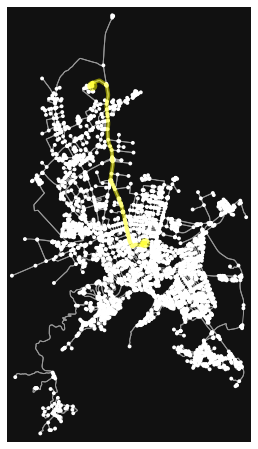

(<Figure size 576x576 with 1 Axes>, <Axes: >)

In [4]:
# Plot the street network
fig, ax = ox.plot_graph(G_projected, show=False, close=False)
# Plot the route on top of the street network
ox.plot_graph_route(G_projected, route, ax=ax, route_color='yellow', route_linewidth=4, node_size=0, bgcolor='k')

In [ ]:
graph_file_geographical = "graph_geographical_coords.pkl"
graph_file_cartesian = "graph_cartesian_coords.pkl"

# Save the geographical graph
with open(graph_file_geographical, "wb") as f:
    pickle.dump(G, f)

# Save the projected graph
with open(graph_file_cartesian, "wb") as f:
    pickle.dump(G_projected, f)

In [137]:
'''
def get_points_inside_circle(nodes_geographical, radius, center_point):
    inside_circle_nodes = []
    indexs = []
    # Convert node coordinates to Cartesian for distance calculation
    for index, node in nodes_geographical.iterrows():
        node_x = node['geometry'].x
        node_y = node['geometry'].y
        node_cartesian = Point(geographical_to_cartesian(node_y, node_x))

        # Check if the point falls within the circle
        if center_point.distance(node_cartesian) <= radius:
                inside_circle_nodes.append(Point(node_y, node_x))
                indexs.append(index)
            
    # Convert the nodes into geographical coords
    # Create a GeoDataFrame from the points inside the circle
    inside_circle_gdf = gpd.GeoDataFrame(geometry=inside_circle_nodes, crs=nodes_geographical.crs)
    
    # Convert the coordinates of the GeoDataFrame to EPSG:4326
    #inside_circle_gdf = inside_circle_gdf.to_crs(epsg=4326)
  
    # Set index column to indexx
    inside_circle_gdf.index = indexs
    
    return inside_circle_gdf
'''

In [147]:
'''
# Create a Folium map centered at the center of the route
m = folium.Map(location=[center_point_geographical.x, center_point_geographical.y], zoom_start=12)

# Add the route to the map
for geom in route_gdf_geographical['geometry']:
    coords = [(coord[1], coord[0]) for coord in geom.coords]  # Use (latitude, longitude) order
    folium.PolyLine(locations=coords, color='blue').add_to(m)

# Iterate over all nodes in the nodes GeoDataFrame and add nodes inside the circle to the map
for index, node in nodes_geographical.iterrows():
    node_x = node['geometry'].x
    node_y = node['geometry'].y
    
    # Convert node coordinates to Cartesian for distance calculation

    node_cartesian = Point(geographical_to_cartesian(node_y, node_x))
    
    # Check if the point falls within the circle
    if center_point_cartesian.distance(node_cartesian) <= radius:
        folium.CircleMarker(location=[node_y, node_x], radius=5, color='green', fill=True, fill_color='magenta').add_to(m)
        indx.append((node_y, node_x))

# Create a circle
circle = folium.Circle(location=[center_point_geographical.x, center_point_geographical.y], radius=radius, color='yellow', fill=True, fill_opacity=0.2)
circle.add_to(m)

# Display the map
m
'''

In [167]:
# Create a Folium map centered at the center of the route
m = folium.Map(location=[center_point_geographical.x, center_point_geographical.y], zoom_start=12)

# Add the route to the map
for geom in route_gdf_geographical['geometry']:
    coords = [(coord[1], coord[0]) for coord in geom.coords]  # Use (latitude, longitude) order
    folium.PolyLine(locations=coords, color='blue').add_to(m)

for geom in inside_nodes['geometry']:
    node_x = geom.x
    node_y = geom.y 
    folium.CircleMarker(location=[node_y, node_x], radius=5, color='green', fill=True, fill_color='magenta').add_to(m)


# Create a circle
circle = folium.Circle(location=[center_point_geographical.x, center_point_geographical.y], radius=radius, color='yellow', fill=True, fill_opacity=0.2)
circle.add_to(m)

# Display the map
m